In [5]:
%cd /root/share/Real/KAIST/CD_Flow/
%load_ext autoreload
%autoreload 2

/root/share/Real/KAIST/CD_Flow
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!pip install git+https://github.com/VLL-HD/FrEIA.git tensorboard pytorch-ignite==0.4.2 umap-learn

  Cloning https://github.com/VLL-HD/FrEIA.git to /tmp/pip-req-build-e33vwvos
  Running command git clone -q https://github.com/VLL-HD/FrEIA.git /tmp/pip-req-build-e33vwvos


In [54]:
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA

import umap

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import torch
import torch.nn as nn
import torch.nn.functional as F

import model_flow
import constant as const
import utils
import main

import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [7]:
df = pd.read_csv("Data/no_alien_processing0_fillNA.csv")

info = {
    0: [df['bmi']>=25, ['bmi', 'height', 'weight', 'waist']],
    1: [df['blood_sugar']>=126, ['blood_sugar']],
    2: [df['neutral_fat']>=np.log1p(200), ['neutral_fat']],
    3: [(df['hdl']<40)|(df['ldl']>=160), ['hdl', 'ldl']],
    4: [(df['got']>np.log1p(40))|(df['gpt']>np.log1p(40)), ['got', 'gpt']],
    5: [df['hemoglobin']+df['gender']<13, ['hemoglobin']],
    6: [(df['max_bp']>=130)|(df['min_bp']>80), ['max_bp', 'min_bp']]
}

df = df.drop(df.columns[:63], axis=1)

def init_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [8]:
diseases = np.where(info[1][0], 1, 0)
encoder = LabelEncoder()
diseases = encoder.fit_transform(diseases)

normal = df[diseases == 0]
diseases = df[diseases == 1] 
x_diseases = diseases.drop(columns=info[1][1], axis=1)
y_diseases = pd.DataFrame(np.ones(len(x_diseases)), columns=['diseases'], index=x_diseases.index)
x_normal = normal.drop(columns=info[1][1], axis=1)
y_normal = pd.DataFrame(np.zeros(len(x_normal)), columns=['diseases'], index=x_normal.index)

x_train, x_test, y_train, y_test = train_test_split(x_normal, y_normal, test_size=0.2, stratify=normal['gender'])
x_test = pd.concat([x_test, x_diseases])
y_test = pd.concat([y_test, y_diseases])

c_train = torch.FloatTensor(x_train[['age', 'gender']].values).to('cuda')
c_test = torch.FloatTensor(x_test[['age', 'gender']].values).to('cuda')

c_test_positive = torch.FloatTensor(x_test[['age', 'gender']][y_test['diseases']==1].values).to('cuda')
c_test_negative = torch.FloatTensor(x_test[['age', 'gender']][y_test['diseases']==0].values).to('cuda')

x_train.drop(['age', 'gender'], axis=1, inplace=True)
x_test.drop(['age', 'gender'], axis=1, inplace=True)
train_columns = x_train.columns

scaler = RobustScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train[x_train.columns])
x_test[x_test.columns] = scaler.transform(x_test[x_test.columns])

test_positive = torch.FloatTensor(x_test[y_test['diseases'] == 1].values).to('cuda')
test_negative = torch.FloatTensor(x_test[y_test['diseases'] == 0].values).to('cuda')

x_train = torch.FloatTensor(x_train.values).to('cuda')
x_test = torch.FloatTensor(x_test.values).to('cuda')

In [9]:
init_seeds(51)

In [18]:
model = model_flow.CD_Flow(
    dim_features = 48,
    flow_steps = const.FLOW_STEPS,
    cond_dims = 2
).to('cuda')

#model.load_state_dict(torch.load('Outputs/Flow/1028/exp1/199.pt')['model_state_dict'])
model.load_state_dict(torch.load('_experiments/exp9/99.pt')['model_state_dict'])
model.eval()
#mean = torch.mean(model(x_train, c_train)['output'], dim=0)
#std = torch.std(model(x_train, c_train)['output'], dim=0)
mean = model.base.base_mean.cpu().detach().numpy()
std = torch.exp(model.base.base_cov).cpu().detach().numpy()

sample_size = 100

In [11]:
np.abs(np.mean(model(test_negative, c_test_negative)['output'].cpu().detach().numpy(), axis=0))

array([0.0653752 , 0.1020627 , 0.26647416, 0.03342432, 0.20397872,
       0.64816386, 0.13371034, 0.0249432 , 0.2028259 , 0.06843049,
       0.1374464 , 0.65497893, 0.39562857, 0.46163782, 0.13517031,
       0.19227411, 0.09786917, 0.06450962, 0.1897048 , 0.155072  ,
       0.04584734, 0.19445266, 0.32775602, 0.39356282, 0.38816363,
       0.06332035, 0.20555653, 0.40365815, 0.03271101, 0.2595415 ,
       0.5377446 , 0.46639153, 0.4446144 , 0.17564695, 0.22278327,
       0.19367708, 0.2980102 , 0.2376962 , 0.18394266, 0.6513436 ,
       0.02240444, 0.06582066, 0.17657532, 0.14395458, 0.7689957 ,
       0.7957791 , 0.15402432, 0.05927992], dtype=float32)

In [22]:
np.std(model(test_negative, c_test_negative)['output'].cpu().detach().numpy(), axis=0)

array([1.1760612 , 0.37766674, 0.79719937, 0.6686476 , 0.6968632 ,
       0.9637768 , 0.8601733 , 0.80291224, 1.1869559 , 0.7837364 ,
       0.77089125, 0.7783241 , 0.69721985, 0.8641223 , 0.5222065 ,
       0.7660814 , 1.0875909 , 1.1380879 , 1.2948602 , 0.7381637 ,
       0.77901894, 0.7995407 , 0.8607603 , 0.7997522 , 1.010989  ,
       0.6040653 , 0.7031399 , 0.84320915, 0.9174266 , 0.93660384,
       0.74738085, 0.6367509 , 0.80922586, 0.92604804, 0.6792159 ,
       1.3985121 , 0.71912915, 0.8332724 , 0.70044804, 1.00429   ,
       0.7811791 , 0.96834415, 0.9193906 , 0.5373087 , 0.76461166,
       0.9766222 , 0.93218553, 1.0077779 ], dtype=float32)

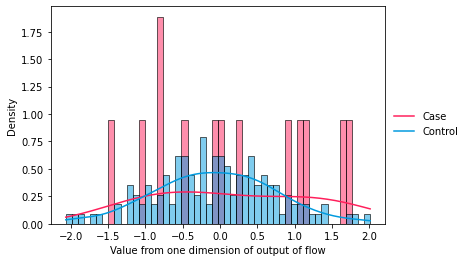

In [67]:
mpt.rcParams['axes.prop_cycle'] = mpt.cycler(color=["009ADE", "FF1F5B"]) 

c=9
pos_sample = model(test_positive, c_test_positive)['output'][:,c].cpu().detach().numpy()
neg_sample = model(test_negative, c_test_negative)['output'][:,c].cpu().detach().numpy()
sample = np.concatenate((neg_sample, pos_sample))
label = np.concatenate((np.zeros(len(neg_sample)).astype('int'), np.ones(len(pos_sample)).astype('int')))
label = np.where(label==0, 'Control', 'Case')
sample = pd.DataFrame({'value':sample, 'label':label})

sns.histplot(sample, bins=50, x='value', hue='label', stat='density', kde=True, common_norm=False, color=['FF1F5B', '009ADE'])
plt.xlabel('Value from one dimension of output of flow')
plt.legend(loc='upper left', labels=['Case', 'Control'], bbox_to_anchor=(1.0, 0.56), frameon=False)
plt.savefig('Outputs/Density.png', dpi=1000)

<AxesSubplot:xlabel='value', ylabel='Density'>

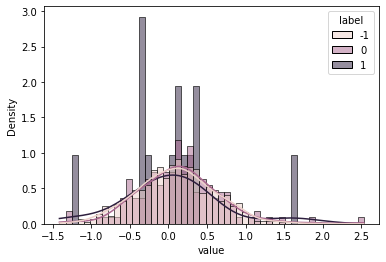

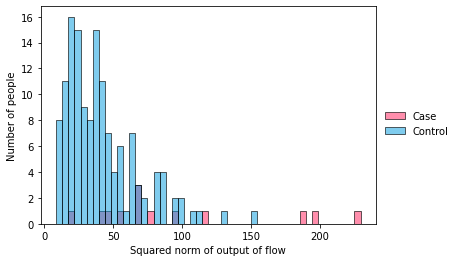

In [68]:
mpt.rcParams['axes.prop_cycle'] = mpt.cycler(color=["009ADE", "FF1F5B"]) 

test_positive_distance = model(test_positive, c_test_positive)['output'].cpu().detach().numpy()
test_positive_distance = np.sum(test_positive_distance ** 2, axis=1)

test_negative_distance = model(test_negative, c_test_negative)['output'].cpu().detach().numpy()
test_negative_distance = np.sum(test_negative_distance ** 2, axis=1)

x_test_flow_distance = np.concatenate((test_negative_distance, test_positive_distance))
label = np.concatenate((np.zeros(len(test_negative_distance)).astype('int'), np.ones(len(test_positive_distance)).astype('int')))
label = np.where(label==0, 'Control', 'Case')
x_test_flow_distance = pd.DataFrame({'distance':x_test_flow_distance, 'label':label})

sns.histplot(x_test_flow_distance, bins=50, x='distance', hue='label')

plt.xlabel('Squared norm of output of flow')
plt.ylabel('Number of people')
plt.legend(loc='upper left', labels=['Case', 'Control'], bbox_to_anchor=(1.0, 0.56), frameon=False)
plt.savefig('Outputs/Histogram.png', dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


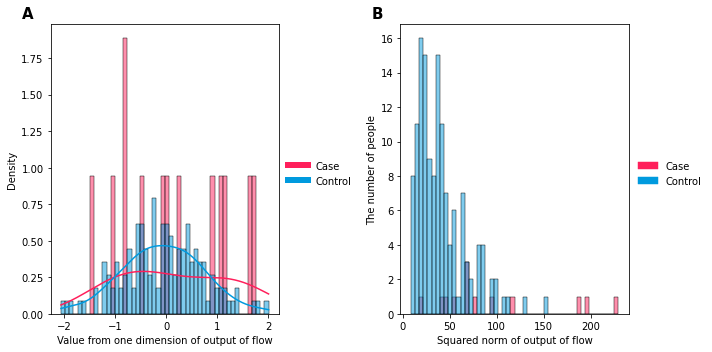

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

mpt.rcParams['axes.prop_cycle'] = mpt.cycler(color=["009ADE", "FF1F5B"]) 
c=9
pos_sample = model(test_positive, c_test_positive)['output'][:,c].cpu().detach().numpy()
neg_sample = model(test_negative, c_test_negative)['output'][:,c].cpu().detach().numpy()
sample = np.concatenate((neg_sample, pos_sample))
label = np.concatenate((np.zeros(len(neg_sample)).astype('int'), np.ones(len(pos_sample)).astype('int')))
label = np.where(label==0, 'Normal', 'Diabetes')
sample = pd.DataFrame({'value':sample, 'label':label})

sns.histplot(sample, ax = ax[0], bins=50, x='value', hue='label', stat='density', kde=True, common_norm=False)

ax[0].legend(loc='upper left', labels=['Case', 'Control'], bbox_to_anchor=(1.0, 0.56), frameon=False)
ax[0].set_xlabel('Value from one dimension of output of flow')
ax[0].set_title('A', position=(-0.1, 0), fontsize=15, weight="bold")

for line in ax[0].get_legend().get_lines():
    line.set_linewidth(6)

test_positive_distance = model(test_positive, c_test_positive)['output'].cpu().detach().numpy()
test_positive_distance = np.sum(test_positive_distance ** 2, axis=1)

test_negative_distance = model(test_negative, c_test_negative)['output'].cpu().detach().numpy()
test_negative_distance = np.sum(test_negative_distance ** 2, axis=1)

x_test_flow_distance = np.concatenate((test_negative_distance, test_positive_distance))
label = np.concatenate((np.zeros(len(test_negative_distance)).astype('int'), np.ones(len(test_positive_distance)).astype('int')))
label = np.where(label==0, 'Normal', 'Diabetes')
x_test_flow_distance = pd.DataFrame({'distance':x_test_flow_distance, 'label':label})


mpt.rcParams['axes.prop_cycle'] = mpt.cycler(color=["009ADE", "FF1F5B"]) 
sns.histplot(x_test_flow_distance, ax = ax[1], bins=50, x='distance', hue='label')

ax[1].legend(loc='upper left', labels=['Case', 'Control'], bbox_to_anchor=(1.0, 0.56), frameon=False)
ax[1].set_xlabel('Squared norm of output of flow')
ax[1].set_ylabel('The number of people')
ax[1].set_title('B', position=(-0.1, 0), fontsize=15, weight="bold")

for line in ax[1].get_legend().get_lines():
    line.set_linewidth(6)

ax[1].get_legend().legendHandles[0].set_color('#FF1F5B')
ax[1].get_legend().legendHandles[1].set_color('#009ADE')

plt.tight_layout()
plt.savefig('Outputs/Distribution.eps', format='eps') #500

In [64]:
x_normal_raw = pd.DataFrame(np.array(test_negative.detach().cpu()), columns=train_columns)
x_diseases_raw = pd.DataFrame(np.array(test_positive.detach().cpu()), columns=train_columns)
x_test_raw = pd.concat([x_normal_raw, x_diseases_raw], axis=0)
x_train_raw = pd.DataFrame(np.array(x_train.detach().cpu()), columns=train_columns)

x_normal_flow = pd.DataFrame(np.array(model(test_negative, c_test_negative)['output'].detach().cpu()), columns=train_columns)
x_diseases_flow = pd.DataFrame(np.array(model(test_positive, c_test_positive)['output'].detach().cpu()), columns=train_columns)
x_test_flow = pd.concat([x_normal_flow, x_diseases_flow], axis=0)
x_train_flow = pd.DataFrame(np.array(model(x_train, c_train)['output'].detach().cpu()), columns=train_columns)

x_test_flow = pd.concat([x_normal_flow, x_diseases_flow], axis=0)

<AxesSubplot:xlabel='score', ylabel='Count'>

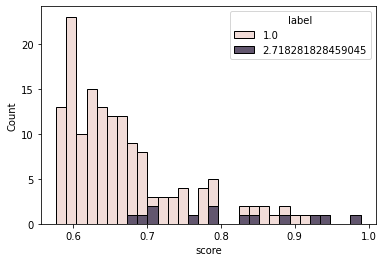

In [100]:
x_normal_flow_score = np.array(model(test_negative, c_test_negative)['score'].detach().cpu())
x_diseases_flow_score = np.array(model(test_positive, c_test_positive)['score'].detach().cpu())
x_test_flow_score = np.concatenate((x_normal_flow_score, x_diseases_flow_score))
label = np.concatenate((np.zeros(len(x_normal_flow_score)).astype('int'), np.ones(len(x_diseases_flow_score)).astype('int')))
x_test_flow_score = pd.DataFrame({'score':x_test_flow_score, 'label':label})
sns.histplot(np.exp(x_test_flow_score), x='score', hue='label', multiple='stack', bins=30)

[0.19282652 0.1391158  0.11643492 0.06916475 0.06342607 0.05803292
 0.05235672 0.04310782 0.04195299 0.03165019]


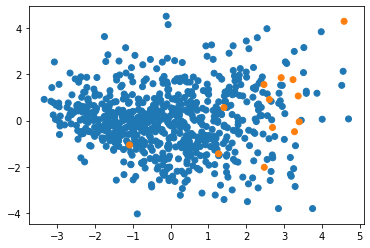

In [142]:
pca = PCA(n_components=10)
#x_train_raw_pca = pca.fit_transform(x_train_flow)
#x_test_raw_pca = pca.transform(x_test_flow)
#print(pca.explained_variance_ratio_)

#x_pca = np.concatenate((x_train_raw_pca, x_test_raw_pca))
x_pca = pca.fit_transform(pd.concat([x_train_flow, x_test_flow]))
print(pca.explained_variance_ratio_)

plt.scatter(
    x_pca[:, 0],
    x_pca[:, 1],
    c=[sns.color_palette()[z] for z in np.concatenate((np.zeros(len(x_normal_raw)+len(x_train_raw)).astype('int'), np.ones(len(x_diseases_raw)).astype('int')))]
)

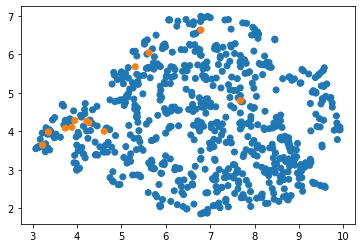

In [143]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0, set_op_mix_ratio=0.25, metric="euclidean")
#embedding_normal = reducer.fit_transform(x_normal)
#embedding_diseases = reducer.transform(x_diseases)
#reducer.fit(x_train_flow)
embedding = reducer.fit_transform(pd.concat([x_train_flow, x_test_flow]))

#embedding = np.concatenate((embedding_normal, embedding_diseases), axis=0)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[z] for z in np.concatenate((np.zeros(len(x_normal_raw)+len(x_train_raw)).astype('int'), np.ones(len(x_diseases_raw)).astype('int')))]
    #c=[sns.color_palette()[z] for z in np.concatenate((np.zeros(len(x_normal_raw)).astype('int'), np.ones(len(x_diseases_raw)).astype('int')))]
)

In [ ]:
c=43
train_sample = model(x_train, c_train)['output'][:,c].cpu().detach().numpy()
pos_sample = model(test_positive, c_test_positive)['output'][:,c].cpu().detach().numpy()
neg_sample = model(test_negative, c_test_negative)['output'][:,c].cpu().detach().numpy()
sample = np.concatenate((train_sample, neg_sample, pos_sample))
label = np.concatenate((np.full(len(train_sample), -1), np.zeros(len(neg_sample)).astype('int'), np.ones(len(pos_sample)).astype('int')))
#label = np.where(label==0, 'Normal', 'Diabetes')
sample = pd.DataFrame({'value':sample, 'label':label})

sns.histplot(sample, bins=50, x='value', hue='label', stat='density', kde=True, common_norm=False)